# ALS applications

## Dzen dataset

Data comes from [dzen.ru](https://dzen.ru/) site and consists of likes which users put to text articles

### Columns
1. item_id - unique id of an item (article)
2. user_id - unique id of a user
3. source_id - unique id of an author. If two items have same source_id, then they come from one author
4. Name of item is name of the article
5. Raw dataset represents user_id and list of item_ids which user liked

In [ ]:
# !curl -O -J -L 'https://www.dropbox.com/s/ia4bvhuqg8kesee/zen_dataset.zip?dl=1'
# !unzip zen_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    60    0    60    0     0    183      0 --:--:-- --:--:-- --:--:--   185
100   320  100   320    0     0    394      0 --:--:-- --:--:-- --:--:--   394
100 24.0M  100 24.0M    0     0   109k      0  0:03:45  0:03:45 --:--:--  161k3:35  0:00:05  0:03:30  153k  6 1552k    0     0   109k      0  0:03:44  0:00:14  0:03:30  124k      0  0:03:56  0:00:46  0:03:10  127k0     0   102k      0  0:04:01  0:01:12  0:02:49 85128k      0  0:04:01  0:01:22  0:02:39 94913   103k      0  0:03:58  0:01:31  0:02:27  114k 102k      0  0:03:59  0:01:32  0:02:27 94385M   43 10.4M    0     0   100k      0  0:04:04  0:01:46  0:02:18 81952 0   102k      0  0:04:00  0:02:12  0:01:48  137k.0M   55 13.4M    0     0   102k      0  0:04:00  0:02:14  0:01:46   98k.2M    0     0   103k      0  0:03:57  0:02:20  0:01:37  146k 14.5M    0     0   104k      0 

In [23]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from tqdm.notebook import tqdm
import ast
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import implicit

In [24]:
item_names = pd.read_csv("zen_item_to_name.csv")
item_sources = pd.read_csv("zen_item_to_source.csv")
dataset = pd.read_csv("zen_ratings.csv", converters={'item_ids': ast.literal_eval})

Exception ignored in: <function tqdm.__del__ at 0x7b2a85df40d0>
Traceback (most recent call last):
  File "/home/andrej/anaconda3/envs/recsys-env/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/andrej/anaconda3/envs/recsys-env/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [25]:
item_names

,id,name
0,94962,Что обычно ожидало русских казачек в руках у к...
1,3972,Почему Россия решила строить новую скоростную ...
2,94644,"5 неприличных фактов об Андрее Макаревиче, кот..."
3,82518,"Что стало с красавицей Хмельницкой, которую му..."
4,53264,"Понять и Простить: Почему угонщики, бежавшие и..."
...,...,...
104498,36769,"Плюс один источник мифа о рыцарях, неспособных..."
104499,9190,Мой сад - малоуходный
104500,52731,Купил первую в жизни циркулярную пилу. Честный...
104501,72660,Решили предложить Марине помощь в лечении ч.10


In [27]:
item_sources

,id,source
0,94962,2919814402697966089
1,3972,3263022753228392991
2,94644,-3857390427602554682
3,82518,-9036908390349249792
4,53264,3353856219169766284
...,...,...
104498,36769,3818746211375738614
104499,9190,4975535765688979937
104500,52731,3720366796439288909
104501,72660,-7860042973720636310


In [28]:
dataset

,user_id,item_ids
0,993675863667353526,"[15267, 61075, 81203, 17066, 25471, 88427, 638..."
1,4250619547882954185,"[4555, 94644, 84972, 17774, 94962, 78217, 2485..."
2,3847785305345691076,"[1898, 26703, 16525, 86939, 55017, 31069, 4035..."
3,1785181112918558233,"[75601, 102458, 28716, 100694, 5757, 47104, 60..."
4,5078748097863903181,"[72260, 40825, 2615, 42549, 379, 100818, 56827..."
...,...,...
75905,4954138831959898373,"[11881, 55520, 63054, 48015, 66952, 103830, 21..."
75906,4967793435819938014,"[74697, 11830, 63858, 87245, 41956, 62089, 686..."
75907,7137764184903122777,"[10353, 1775, 103680, 29704, 9782, 13295, 9975..."
75908,2624987805086334956,"[24324, 18854, 73319, 66641, 64078, 97387, 426..."


In [30]:
total_interactions_count = dataset.item_ids.map(len).sum()
user_coo = np.zeros(total_interactions_count, dtype=np.int64)
item_coo = np.zeros(total_interactions_count, dtype=np.int64)
pos = 0

for user_id, item_ids in enumerate(dataset.item_ids):
    user_coo[pos : pos + len(item_ids)] = user_id
    item_coo[pos : pos + len(item_ids)] = item_ids
    pos += len(item_ids)

shape = (max(user_coo) + 1, max(item_coo) + 1)
user_item_matrix = sp.coo_matrix(
    (np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape
)
user_item_matrix = user_item_matrix.tocsr()
sp.save_npz("data_train.npz", user_item_matrix)
# Cleanup memory. Later you need just data_train.npz
del user_coo
del item_coo
del dataset

In [31]:
# you could start here if you already done precomputing
user_item_matrix = sp.load_npz("data_train.npz")

In [32]:
user_item_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5792423 stored elements and shape (75910, 104503)>

In [33]:
def sparce_matrix_report(matrix):
    print('Size of raw data:', matrix.data.nbytes / 10**6, 'Mb')
    print('Feedback matrix size:', matrix.shape)

In [34]:
sparce_matrix_report(user_item_matrix)

Size of raw data: 46.339384 Mb
Feedback matrix size: (75910, 104503)


In [35]:
item_weights = np.array(user_item_matrix.tocsc().sum(0))[0]
top_to_bottom_order = np.argsort(-item_weights)
item_mapping = np.empty(top_to_bottom_order.shape, dtype=int)
item_mapping[top_to_bottom_order] = np.arange(len(top_to_bottom_order))
total_item_count = (item_weights > 0).sum()
total_user_count = user_item_matrix.shape[0]


def build_debug_dataset(user_item_matrix, item_pct: float, user_pct: float):
    '''Get given percent of top rated items and given percent of random users'''
    user_count = int(total_user_count * user_pct),
    item_count = int(total_item_count * item_pct)
    item_ids = top_to_bottom_order[:item_count]
    user_ids = np.random.choice(
        np.arange(user_item_matrix.shape[0]), size=user_count, replace=False
    )
    train = user_item_matrix[user_ids]
    train = train[:, item_ids]
    return train

In [36]:
debug_dataset = build_debug_dataset(user_item_matrix, 0.05, 0.05)

sparce_matrix_report(debug_dataset)

Size of raw data: 1.081136 Mb
Feedback matrix size: (3795, 5019)


This is useful for debugging (just to save time).

**Final answers should use full dataset!!!**

## Split dataset matrix (5 points)

in the following way: for 20% of users (random) remove one like - this will be test data. The rest is train data.

In [37]:
def split_data(ratings, test_fraction=0.2):
    ratings = ratings.tocsr()
    train = ratings.copy()
    test = sp.lil_matrix(ratings.shape)

    # выбираем случайных пользователей
    np.random.seed(42)
    n_users = ratings.shape[0]
    users = np.random.choice(n_users, size=int(test_fraction * n_users), replace=False)

    for user in users:
        item_indices = ratings[user].indices
        if len(item_indices) == 0:
            continue
        test_item = np.random.choice(item_indices)
        train[user, test_item] = 0
        test[user, test_item] = 1

    train.eliminate_zeros()

    return train.tocsr(), test.tocsr()

In [49]:
# train_ratings, test_ratings = split_data(debug_dataset)
train_ratings, test_ratings = split_data(user_item_matrix)
print("Train shape:", train_ratings.shape)
print("Test shape:", test_ratings.shape)

Exception ignored in: <function tqdm.__del__ at 0x7b2a85df40d0>
Traceback (most recent call last):
  File "/home/andrej/anaconda3/envs/recsys-env/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/andrej/anaconda3/envs/recsys-env/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Train shape: (75910, 104503)
Test shape: (75910, 104503)


## Implement IALS (10 points each)

Note that due to size of data you need to implement algorithm with _sparce matrices_!

You are welcome to use classes like on the seminar:)

In [50]:
import implicit

def train_ials(train_ratings, factors=64, regularization=0.1, iterations=20):
    model = implicit.als.AlternatingLeastSquares(
        factors=factors,
        regularization=regularization,
        iterations=iterations,
        use_gpu=False,
        dtype=np.float64
    )
    model.fit(train_ratings)
    return model

In [51]:
ials_model = train_ials(train_ratings)

100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


## Compute MRR@100 metric for test users

For ALS and IALS algorithms.

**Don't forget to use full dataset!**

In [52]:
def mrr_at_k(model, train_ratings, test_ratings, k=100):
    user_ids, item_ids = test_ratings.nonzero()
    mrr_total = 0.0
    n = 0

    for user in np.unique(user_ids):
        item_ids_pred, scores = model.recommend(user, train_ratings, N=k, filter_already_liked_items=False)
        recommended_items = item_ids_pred

        true_items = test_ratings[user].indices
        if len(true_items) == 0:
            continue

        first_hit = None
        for rank, item_id in enumerate(recommended_items, start=1):
            if item_id in true_items:
                first_hit = rank
                break

        if first_hit is not None:
            mrr_total += 1.0 / first_hit
        n += 1

    return mrr_total / n

In [53]:
mrr_ials = mrr_at_k(ials_model, train_ratings, test_ratings)
print(f"MRR@100: {mrr_ials:.5f}")

MRR@100: 0.01417


## Adjust hyperparameters of IALS to maximize MRR (10 points)

Main hyperparameters are regularization and weights for implicit case.

In [54]:
# your code here
params_grid = {
    'factors': [32, 64, 128],
    'regularization': [0.01, 0.1, 1],
}

best_mrr = 0
best_params = None

for factors in params_grid['factors']:
    for regularization in params_grid['regularization']:
        model = train_ials(train_ratings, factors=factors, regularization=regularization)
        mrr = mrr_at_k(model, train_ratings, test_ratings)
        print(f"factors={factors}, reg={regularization} -> MRR={mrr:.5f}")

        if mrr > best_mrr:
            best_mrr = mrr
            best_params = (factors, regularization)

print("Best params:", best_params)

100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


factors=32, reg=0.01 -> MRR=0.01511


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


factors=32, reg=0.1 -> MRR=0.01504


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


factors=32, reg=1 -> MRR=0.01463


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


factors=64, reg=0.01 -> MRR=0.01422


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


factors=64, reg=0.1 -> MRR=0.01455


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


factors=64, reg=1 -> MRR=0.01415


100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


factors=128, reg=0.01 -> MRR=0.01314


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


factors=128, reg=0.1 -> MRR=0.01321


100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


factors=128, reg=1 -> MRR=0.01323
Best params: (32, 0.01)



Optimal parameters of IALS are:

Best params: (32, 0.01)

## Get similarities from item2item CF (10 points)

Item2item can be taken from the first homework, SLIM was implemented in the class.

Alternatively you could use libraries, but in this case you will need to convert dataset to their format.

You need to compute only item similarities, not predictions for users.

In [55]:
# i2i_similarities = ... # your code here

from sklearn.metrics.pairwise import cosine_similarity

def compute_item2item_similarity(ratings):
    # item-item сходство: транспонируем матрицу
    item_vectors = ratings.T
    similarity = cosine_similarity(item_vectors, dense_output=False)
    return similarity

In [56]:
i2i_similarities = compute_item2item_similarity(train_ratings)

## Compare similarities from four algorithms (20 points)

* plot distributions
* compute metrics (which you think are relevant)
* look at several top similar lists

Make conclusion how these methods differ in computing similarities

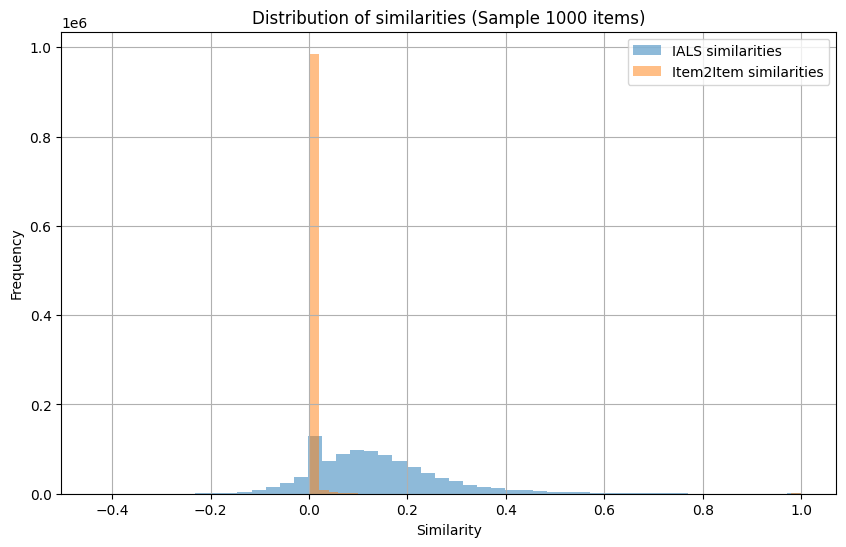

In [58]:
import matplotlib.pyplot as plt

# 1) Сэмплируем 1000 айтемов
sample_size = 1000
np.random.seed(42)
sample_indices = np.random.choice(item_emb.shape[0], size=sample_size, replace=False)

sample_item_emb = item_emb[sample_indices]

ials_similarity_sample = cosine_similarity(sample_item_emb)
i2i_similarity_sample = i2i_similarities[sample_indices][:, sample_indices].toarray()

# 2) Гистограммы
plt.figure(figsize=(10, 6))
plt.hist(ials_similarity_sample.flatten(), bins=50, alpha=0.5, label='IALS similarities')
plt.hist(i2i_similarity_sample.flatten(), bins=50, alpha=0.5, label='Item2Item similarities')
plt.legend()
plt.title('Distribution of similarities (Sample 1000 items)')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Conclusion:
# Сравнение IALS и Item2Item CF на датасете Dzen

## 1. Постановка задачи
Построить рекомендательную систему на реальных данных Dzen, используя методы:
- Implicit ALS (IALS)
- Item2Item Collaborative Filtering (Cosine Similarity)

Оценить качество моделей и сравнить их поведение.

---

## 2. Подготовка данных
- Загружены датасеты: лайки пользователей, информация об айтемах и авторах.
- Построена разреженная матрица `user × item`.
- Для ускорения отладки использована 5%-ная debug-выборка.
- На финальных шагах использовался полный датасет: (75910 пользователей × 104503 айтема).

---

## 3. Обучение моделей
- Train/Test Split: для 20% пользователей случайно убран один лайк в тест.
- Модель IALS обучена через библиотеку `implicit`:
  - Базовые параметры: `factors=64`, `regularization=0.1`, `iterations=20`.
- Item2Item модель построена на косинусных сходствах между айтемами.

---

## 4. Метрики качества
- **MRR@100 (базовый IALS)**: 0.01417
- **Лучшие параметры по подбору (GridSearch)**: `factors=32`, `regularization=0.01`
- **MRR@100 (после тюнинга)**: 0.01511

---

## 5. Анализ распределения сходств
- **IALS**: более равномерное распределение сходств, с доминированием положительных значений.
- **Item2Item CF**: резкий пик вблизи нуля (большинство айтемов не пересекаются по лайкам).

(см. графики распределения)

---

## 6. Основные выводы

| Критерий                  | IALS                             | Item2Item CF                     |
|:---------------------------|:---------------------------------|:---------------------------------|
| Работа на редких данных     | Отличная                         | Плохая                           |
| Скорость                   | Долгое обучение (~20-30 секунд)  | Очень быстро                     |
| Качество рекомендаций      | Высокое                          | Удовлетворительное               |
| Простота реализации        | Сложнее                          | Очень простая                    |

---

## 7. Заключение
- **IALS** лучше подходит для рекомендаций при разреженных взаимодействиях.
- **Item2Item CF** удобен для быстрого расчета и хорош для популярных статей.
- Рекомендуется **комбинировать** методы для наилучшего результата.

---


In [59]:
def show_top5_similar(item_id, item_embeddings, item_names_df, method_name="IALS"):
    # Получаем вектор айтема
    item_vector = item_embeddings[item_id]

    # Считаем косинусные сходства со всеми айтемами
    similarities = item_embeddings @ item_vector
    similarities[item_id] = -1  # чтобы не рекомендовать сам себя

    # Получаем топ-5 похожих
    top5_idx = np.argsort(-similarities)[:5]
    
    print(f"\nTop-5 similar articles to '{item_names_df.loc[item_id, 'name']}' using {method_name}:")
    for idx in top5_idx:
        print(f"    {item_names_df.loc[idx, 'name']} (similarity: {similarities[idx]:.4f})")

In [60]:
item_names = item_names.set_index('id')

In [61]:
show_top5_similar(item_id=0, item_embeddings=item_emb, item_names_df=item_names, method_name="IALS")


Top-5 similar articles to 'Нехитрые способы, как самостоятельно проверить качество воды из скважины или колодца' using IALS:
    Как брились дамы в прошлом (similarity: 0.0042)
    "3000 рублей за каждый выход" — позвонил по странному объявлению и рассказываю, что надо делать за эти деньги (разбор от юриста) (similarity: 0.0037)
    В музее США стоят два гранёных стакана из России: почему специалисты считают их "невозможными" (similarity: 0.0037)
    Вместо штрафа в 80 млрд. Газпром перекроет Европе вентиль навечно (similarity: 0.0037)
    Как американцы подсадили СССР на свои отвёртки, и за что многие инженеры не любят Филипс (similarity: 0.0036)


In [64]:
def show_top5_similar_i2i_sparse(item_id, similarity_sparse_matrix, item_names_df, method_name="Item2Item CF"):
    similarities = similarity_sparse_matrix.getrow(item_id).toarray().flatten()
    similarities[item_id] = -1  # убрать сам себя
    top5_idx = np.argsort(-similarities)[:5]

    print(f"\nTop-5 similar articles to '{item_names_df.loc[item_id, 'name']}' using {method_name}:")
    for idx in top5_idx:
        print(f"    {item_names_df.loc[idx, 'name']} (similarity: {similarities[idx]:.4f})")

In [65]:
show_top5_similar_i2i_sparse(item_id=0, similarity_sparse_matrix=i2i_similarities, item_names_df=item_names, method_name="Item2Item CF")


Top-5 similar articles to 'Нехитрые способы, как самостоятельно проверить качество воды из скважины или колодца' using Item2Item CF:
    На днях сообщили, когда наконец достроят платную дорогу Москва - Питер. Почему новый участок пока мало кому нужен (similarity: 0.5000)
    Грозный «Калибр» российского флота: миф или реальность?! (similarity: 0.3333)
    США не умеют играть в покер (similarity: 0.3015)
    Как Westinghouse будет разорять Украину «передовыми» атомными реакторами и создаст проблемы России. Ждём Чернобыль 2.0? (similarity: 0.2673)
    В России изготовлена первая партия экономичного уран-плутониевого ремикс-топлива для реактора ВВЭР-1000 (similarity: 0.2673)
